<a href="https://colab.research.google.com/github/AbhayMudgal/Disaster_Identification_From_Tweets/blob/main/Disaster_Tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install kaggle

In [15]:
import os, json
from os import makedirs, listdir
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [3]:
kaggle_json = {"username":"abhay1010","key":"4af3df22394b3bfc76ea750845f8b173"}
makedirs("/content/.kaggle/", exist_ok = True)
makedirs("/root/.kaggle/", exist_ok = True)
with open("/content/.kaggle/kaggle.json", 'w') as file:
  json.dump(kaggle_json, file)

!cp "/content/.kaggle/kaggle.json" "/root/.kaggle/kaggle.json"
!chmod 600 "/content/.kaggle/kaggle.json"
!chmod 600 "/root/.kaggle/kaggle.json"

In [4]:
! kaggle competitions download -c nlp-getting-started

  0% 0.00/22.2k [00:00<?, ?B/s]
100% 22.2k/22.2k [00:00<00:00, 21.3MB/s]
  0% 0.00/411k [00:00<?, ?B/s]
100% 411k/411k [00:00<00:00, 58.4MB/s]
  0% 0.00/965k [00:00<?, ?B/s]
100% 965k/965k [00:00<00:00, 63.2MB/s]


In [68]:
df = pd.read_csv("/content/train.csv")
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


(7613, 5)
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64
(3342,)
(222,)


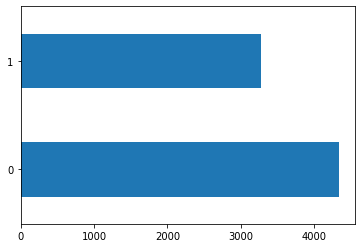

In [69]:
print(df.shape)
print(df.isna().sum())
print(df.location.unique().shape)
print(df.keyword.unique().shape)

df.target.value_counts().plot(kind = 'barh')


In [70]:
test_df = pd.read_csv("/content/test.csv")
print(test_df.shape)
print(test_df.isna().sum())
print(test_df.location.unique().shape)
print(test_df.keyword.unique().shape)
print(test_df.head())

(3263, 4)
id             0
keyword       26
location    1105
text           0
dtype: int64
(1603,)
(222,)
   id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
4  11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiwan


In [71]:
data = df.iloc[:, 3:]
test = test_df.iloc[:, 3]

print(data.head(), '\n') 
print(test.head())

                                                text  target
0  Our Deeds are the Reason of this #earthquake M...       1
1             Forest fire near La Ronge Sask. Canada       1
2  All residents asked to 'shelter in place' are ...       1
3  13,000 people receive #wildfires evacuation or...       1
4  Just got sent this photo from Ruby #Alaska as ...       1 

0                   Just happened a terrible car crash
1    Heard about #earthquake is different cities, s...
2    there is a forest fire at spot pond, geese are...
3             Apocalypse lighting. #Spokane #wildfires
4        Typhoon Soudelor kills 28 in China and Taiwan
Name: text, dtype: object


In [72]:
X = data.text.to_list()
Y = data.target.to_list()
X_test = test.to_list()

In [73]:
import tensorflow as tf
from tensorflow import keras as k
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Embedding, GlobalAveragePooling1D, Dense
from sklearn.model_selection import train_test_split

In [74]:
max_len = 0

total = ''
for line in X:
  total = total + line
  if len(line)>max_len:
    max_len = len(line)

print(max_len)
words = total.split()
words = set(words)
print("Number of unique words in the data: ", len(words))


157
Number of unique words in the data:  31559


In [62]:
Vocab = 50000
oov = '<oov>'
embedding = 32
padding = 'post'
truncate = 'post'
max = max_len

In [75]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state = 1)

tokenizer = Tokenizer(num_words = Vocab, oov_token = oov)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

X_train = tokenizer.texts_to_sequences(X_train)
X_train_pad = pad_sequences(X_train, maxlen=max, padding = padding, truncating = truncate)

X_val = tokenizer.texts_to_sequences(X_val)
X_val_pad = pad_sequences(X_val, maxlen=max, padding = padding, truncating = truncate)

X_test = tokenizer.texts_to_sequences(X_test)
X_test_pad = pad_sequences(X_test, maxlen=max, padding = padding, truncating = truncate)

Y_train = np.array(Y_train)
Y_val =np.array(Y_val)

In [76]:
model = k.Sequential([
                      k.layers.Embedding(Vocab, embedding, input_shape=(max_len,)),
                      k.layers.GlobalAveragePooling1D(),
                      k.layers.Dense(32, activation = 'relu'),
                      k.layers.Dense(8, activation='relu'),
                      k.layers.Dense(1, activation = 'sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 157, 32)           1600000   
_________________________________________________________________
global_average_pooling1d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 1,601,329
Trainable params: 1,601,329
Non-trainable params: 0
_________________________________________________________________


In [66]:
model_check = tf.keras.callbacks.ModelCheckpoint('model.h5',save_best_only = True)
model.fit(X_train_pad, Y_train, epochs = 20, validation_data=(X_val_pad, Y_val), callbacks=[model_check])

Epoch 1/20
191/191 [==============================] - 9s 44ms/step - loss: 0.6821 - accuracy: 0.5681 - val_loss: 0.6741 - val_accuracy: 0.5791
Epoch 2/20
191/191 [==============================] - 10s 52ms/step - loss: 0.6532 - accuracy: 0.6067 - val_loss: 0.6001 - val_accuracy: 0.7269
Epoch 3/20
191/191 [==============================] - 9s 48ms/step - loss: 0.5009 - accuracy: 0.7901 - val_loss: 0.4690 - val_accuracy: 0.7800
Epoch 4/20
191/191 [==============================] - 9s 46ms/step - loss: 0.3494 - accuracy: 0.8662 - val_loss: 0.4809 - val_accuracy: 0.7971
Epoch 5/20
191/191 [==============================] - 7s 34ms/step - loss: 0.2601 - accuracy: 0.9041 - val_loss: 0.4450 - val_accuracy: 0.8037
Epoch 6/20
191/191 [==============================] - 7s 36ms/step - loss: 0.2000 - accuracy: 0.9286 - val_loss: 0.4667 - val_accuracy: 0.8070
Epoch 7/20
191/191 [==============================] - 9s 46ms/step - loss: 0.1512 - accuracy: 0.9504 - val_loss: 0.4963 - val_accuracy: 0.797

In [77]:
#model = tf.keras.backend.clear_session()
vocab = 120000
oov = '<OOV>'
embedding = 32
padding = 'post'
truncate = 'post'
max = max_len

tokenizer = Tokenizer(num_words = vocab, oov_token=oov)
tokenizer.fit_on_texts(X)
word_index = tokenizer.word_index
X = tokenizer.texts_to_sequences(X)
X_pad = pad_sequences(X, maxlen = max, padding = padding, truncating=truncate)

Y = np.array(Y)

epochs = 10


model_check = tf.keras.callbacks.ModelCheckpoint('model.h5',save_best_only = True)
model.fit(X_pad, Y, epochs = epochs, callbacks=[model_check])



Epoch 1/10
238/238 [==============================] - 6s 21ms/step - loss: 0.6855 - accuracy: 0.5650
Epoch 2/10
238/238 [==============================] - 4s 18ms/step - loss: 0.6642 - accuracy: 0.5856
Epoch 3/10
238/238 [==============================] - 5s 21ms/step - loss: 0.5131 - accuracy: 0.7722
Epoch 4/10
238/238 [==============================] - 4s 19ms/step - loss: 0.3809 - accuracy: 0.8434
Epoch 5/10
238/238 [==============================] - 4s 18ms/step - loss: 0.3003 - accuracy: 0.8857
Epoch 6/10
238/238 [==============================] - 4s 18ms/step - loss: 0.2383 - accuracy: 0.9111
Epoch 7/10
238/238 [==============================] - 5s 20ms/step - loss: 0.1934 - accuracy: 0.9297
Epoch 8/10
238/238 [==============================] - 5s 20ms/step - loss: 0.1552 - accuracy: 0.9467
Epoch 9/10
238/238 [==============================] - 5s 21ms/step - loss: 0.1299 - accuracy: 0.9551
Epoch 10/10
238/238 [==============================] - 5s 20ms/step - loss: 0.1015 - accura

Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7f50fab9cb00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/iterator_ops.py", line 546, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1264, in delete_iterator
    _ctx, "DeleteIterator", name, handle, deleter)
KeyboardInterrupt: 


In [87]:
predictions = model.predict(X_test_pad)

pred = []
for i in range(0,len(predictions)):
    if predictions[i][0]>0.5:
        pred.append(1)
    else:
        pred.append(0)

test_df['target'] = pd.Series(pred)

In [89]:
test_df.head()

,id,keyword,location,text,target
0,0,NaN,NaN,Just happened a terrible car crash,0
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",0
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",1
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,0
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,1


In [90]:
submission = pd.DataFrame()
submission['id'] = test_df['id']
submission['target'] = test_df['target']

submission.to_csv("submitssion.csv", index = False)